### This file contains only the training, prediction and evaluation code when the schedule is CosineAnnealingLR

In [1]:
import os
import re
import cv2
import math
import torch
import torchvision

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.functional as F

from PIL import Image
from collections import OrderedDict
from typing import List, Type, Union
from natsort import natsorted
from torch import optim
from torch.autograd import Variable
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchsummary import summary

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Data Augmentation

In [3]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

In [4]:
# mean, std = get_mean_and_std(ImageFolder(root = "./FER-2013/train", transform=transforms.ToTensor()))
# print(mean)
# print(std)

In [5]:
train_transform_compose = transforms.Compose([
    transforms.ToTensor(), 
    
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),     
    transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),   
 
    transforms.RandomErasing(),
    ])

validation_transform_compose = transforms.Compose([
    transforms.ToTensor(), 
    ])

def split_dataset(root, train_ratio, seed):
    dataset1 = ImageFolder(root=root, transform=train_transform_compose) 
    torch.manual_seed(seed)
    train_set, temp1 = torch.utils.data.random_split(dataset=dataset1,\
        lengths=[int(train_ratio*len(dataset1)), math.ceil((1.0-train_ratio)*len(dataset1))]) 
    
    dataset2 = ImageFolder(root=root, transform=validation_transform_compose)
    torch.manual_seed(seed) 
    temp2, validation_set = torch.utils.data.random_split(dataset=dataset2,\
        lengths=[int(train_ratio*len(dataset2)), math.ceil((1.0-train_ratio)*len(dataset2))]) 
    
    return train_set, validation_set

In [6]:
ck_root = "./CK+"
fer_root = "./FER-2013/train"
veg_root = "./vegetable"

train_set, validation_set = split_dataset(fer_root, 0.9, 2022)

print(len(train_set))
print(len(validation_set))

25838
2871


# Data Loader

In [7]:
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size = batch_size,
        shuffle = True,
        num_workers = 0
    )
    return train_loader
    
def validation_loader(batch_size):
    validation_loader = torch.utils.data.DataLoader(
        validation_set,
        batch_size = batch_size,
        shuffle = True,
        num_workers = 0
    )
    return validation_loader

In [8]:
emotion = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [9]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()

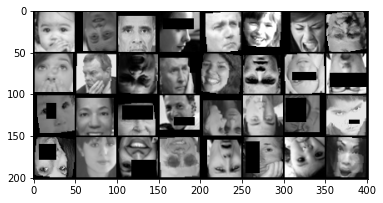

In [10]:
dataiter = iter(train_loader(32))
images, labels = dataiter.next()
timshow(torchvision.utils.make_grid(images))

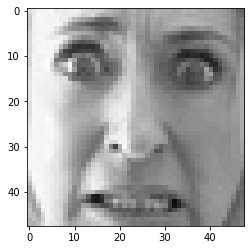

Neutral
tensor([[[[0.8784, 0.9137, 0.9608,  ..., 0.5059, 0.4078, 0.4078],
          [0.8118, 0.9255, 0.9725,  ..., 0.5333, 0.4353, 0.4275],
          [0.7804, 0.9373, 0.9647,  ..., 0.5216, 0.4471, 0.4863],
          ...,
          [0.7412, 0.7176, 0.6392,  ..., 0.3843, 0.4353, 0.4706],
          [0.6980, 0.7451, 0.6902,  ..., 0.4157, 0.4235, 0.4706],
          [0.6980, 0.6784, 0.7294,  ..., 0.4431, 0.4314, 0.4980]],

         [[0.8784, 0.9137, 0.9608,  ..., 0.5059, 0.4078, 0.4078],
          [0.8118, 0.9255, 0.9725,  ..., 0.5333, 0.4353, 0.4275],
          [0.7804, 0.9373, 0.9647,  ..., 0.5216, 0.4471, 0.4863],
          ...,
          [0.7412, 0.7176, 0.6392,  ..., 0.3843, 0.4353, 0.4706],
          [0.6980, 0.7451, 0.6902,  ..., 0.4157, 0.4235, 0.4706],
          [0.6980, 0.6784, 0.7294,  ..., 0.4431, 0.4314, 0.4980]],

         [[0.8784, 0.9137, 0.9608,  ..., 0.5059, 0.4078, 0.4078],
          [0.8118, 0.9255, 0.9725,  ..., 0.5333, 0.4353, 0.4275],
          [0.7804, 0.9373, 0.9647,

In [11]:
dataiter = iter(validation_loader(1))
images, labels = dataiter.next()
timshow(torchvision.utils.make_grid(images))
print(emotion[int(labels)])
print(images)

# Attention

In [12]:
# SE: Squeeze-and-Excitation Attention
# Adapted from GitHub
# https://github.com/xmu-xiaoma666/External-Attention-pytorch/blob/master/model/attention/SEAttention.py
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # 1*1*C
        # Excitation
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),  # 1*1*C/r
            nn.ReLU(inplace=True),  # 1*1*C/r
            nn.Linear(channel // reduction, channel, bias=False),  # 1*1*C
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()  # b:batchsize c:channel
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)

        return x * y.expand_as(x)
    
     
# CBAM: Convolutional Block Attention Module  
# Adapted from GitHub
# https://github.com/xmu-xiaoma666/External-Attention-pytorch/blob/master/model/attention/CBAM.py
class ChannelAttention(nn.Module):
    def __init__(self, channel, reduction=16):
        super(ChannelAttention, self).__init__()
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel//reduction, False),  # 1*1*C/r
            nn.ReLU(inplace=True),  # 1*1*C/r
            nn.Linear(channel//reduction, channel, False)  # 1*1*C
            )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()  # b:batchsize c:channel
        # MaxPool
        max_pool_out = self.max_pool(x).view([b, c])
        max_fc_out = self.fc(max_pool_out).view([b, c, 1, 1])
        # AvgPool
        avg_pool_out = self.avg_pool(x).view([b, c])
        avg_fc_out = self.fc(avg_pool_out).view([b, c, 1, 1])
        out = max_fc_out + avg_fc_out
        out = self.sigmoid(out)
        
        return out * x

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        pool_out = torch.cat([max_out, avg_out], dim=1)  # 2*H*W
        out = self.conv(pool_out)  # 2*H*W -> 1*H*W
        out = self.sigmoid(out)
        
        return out * x


# Model

In [13]:
# Residual neural network
# Adapted from GitHub
# https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/resnet.py
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, reduction=16):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.dropout = nn.Dropout(p=0.1)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out = out + self.shortcut(x)
        out = self.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7, reduction=16):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.ca1 = ChannelAttention(64)
        self.sa1 = SpatialAttention()
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.se2 = SELayer(512, reduction)

        self.fc1 = nn.Linear(512 * block.expansion, 128 * block.expansion)
        self.fc2 = nn.Linear(128 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.ca1(out)
        out = self.sa1(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.se2(out)
        
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out


In [14]:
def Resnet():

    model = ResNet(BasicBlock, [2, 2, 2, 2])  # resnet18
  
    return model


In [15]:
model = Resnet().to(device)

# Training (schedule CosineAnnealingLR)

In [16]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [17]:
def Compute_Loss_Accuracy(loader):
    
    running_loss = 0.0
    n = 0
    total = 0
    correct = 0
    
    net = model.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
                       
            outputs = net(images)  # Forward
            
            # accumulate loss
            running_loss = running_loss + loss_fn(outputs, labels)
            running_loss = running_loss.cpu()
            n = n + 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            correct = correct + (predicted == labels).sum().item()
            total = total + labels.size(0)
            
    return running_loss/n, correct/total 

In [18]:
def Train_Model(epoch_num, bs, pt_name):
    
    loss_path = 'C:/Users/PC/Desktop/MSc Project/' + "loss-" + pt_name
    net_path = 'C:/Users/PC/Desktop/MSc Project/' + "net-" + pt_name
    best_path = 'C:/Users/PC/Desktop/MSc Project/' + "best-" + pt_name
    
    nepochs = epoch_num
    tra_load = train_loader(bs)
    val_load = validation_loader(64)
    
    best_acc = 0.0
    data_recording = np.zeros((4,nepochs+1))
      
    net = model
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs)
    
    for epoch in range(1, nepochs+1):
        
        running_loss = 0.0
        n = 0
        total = 0
        correct = 0    
        
        net = model.train()
        for data in tra_load:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
      
            optimizer.zero_grad()
            outputs = net(inputs)  # Forward
            loss = loss_fn(outputs, labels)  # loss
            loss.backward()  # backward
            optimizer.step()  # update parameters
    
            # accumulate loss
            running_loss = running_loss + loss.item()
            n = n + 1
        
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            correct = correct + (predicted == labels).sum().item()
            total = total + labels.size(0)
    
        train_l = running_loss/n  # mean training loss
        train_a = correct/total  # training accuracy
        
        # mean test loss and test accuracy
        validation_l, validation_a = Compute_Loss_Accuracy(val_load)
        
        scheduler.step()
        # print(f"Learning Rate:{optimizer.param_groups[0]['lr']}")
        
        # save loss and accuracy
        data_recording[:,epoch] = (train_l, train_a, validation_l, validation_a)
        torch.save(data_recording, loss_path)
    
        print(f"Epoch:{epoch}  |  Training Loss:{train_l:.4f} Training Accuracy:{train_a:.1%}  |  Validation Loss:{validation_l:.4f} Validation Accuracy:{validation_a:.1%}")
        
        # save best network parameters
        if validation_a > best_acc:
            best_acc = validation_a
            torch.save({"model_dict": net.state_dict()}, best_path)
        
        # save complete model    
        torch.save({'model_dict' : net.state_dict(),
                    'optimizer_dict' : optimizer.state_dict(),
                    'epoch' : epoch,
                    'scheduler_dict': scheduler.state_dict(),
                    }, net_path)


# Model Training

In [19]:
pt = '6.24-1st' + '.pt'

In [20]:
# Train_Model(200, 128, pt)

# Visualization

In [21]:
def loss_graph(pt_file):
    data = torch.load('loss-' + pt_file)
    plt.title('training and validation loss')
    plt.plot(data[0], 'r', label = 'training loss')
    plt.plot(data[2], 'g', label = 'validation loss')
    plt.ylabel('loss')
    plt.legend(loc='lower left')
    plt.grid()
    plt.show()
    
def accuracy_graph(pt_file):
    data = torch.load('loss-' + pt_file)
    plt.title('training and validation accuracy')
    plt.plot(data[1], 'm', label = 'training accuracy')
    plt.plot(data[3], 'b', label = 'validation accuracy')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

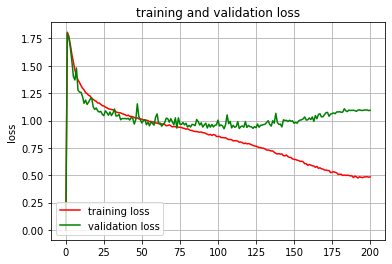

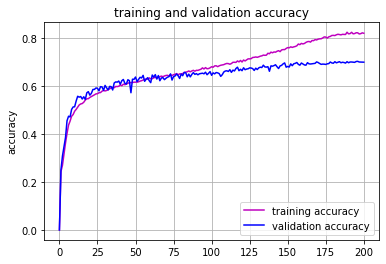

In [22]:
loss_graph(pt)
accuracy_graph(pt)

# Prediction

In [23]:
test_set = ImageFolder(root="./FER-2013/test", transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size = 256,
    shuffle = False,
    num_workers = 0
)

In [24]:
def predict(pt_flie):

    d = torch.load('net-' + pt_flie)
    
    model.load_state_dict(d["model_dict"])
    net = model.to(device).eval()

    correct = 0.0
 
    with torch.no_grad():
        net.eval() 
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
                       
            outputs = net(images)
    
            _, predicted = torch.max(outputs.data, 1)
            correct = correct + (predicted == labels).sum().item()
 
        test_accuracy = correct/len(test_loader.dataset)
        
        print(f"Accuracy:{test_accuracy:.2%}")
        

In [25]:
predict(pt)

Accuracy:70.58%


# Confusion Matrix

In [26]:
classes = tuple(['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
print(classes)

('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')


In [27]:
def accuracy(cnfm):
    return cnfm.trace()/cnfm.sum((0,1))

def recalls(cnfm):
    return np.diag(cnfm)/cnfm.sum(1)

def precisions(cnfm):
    return np.diag(cnfm)/cnfm.sum(0)    

def fscore(p, r):
    f = (2*p*r)/(p+r)
    return f

In [28]:
import itertools

def Confusion_Matrix(pt_flie, loader):
    # load model parameters
    d = torch.load('net-' + pt_flie)
    model.load_state_dict(d["model_dict"])
    net = model.to(device).eval()

    # initialise confusion matrix
    label = np.arange(0, len(classes))
    label_num = label.shape[0]
    
    # confusion matrix tensor
    cnfm = np.zeros((label_num,label_num),dtype=int)

    with torch.no_grad():
        for data in loader:
                      
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = net(images)
        
            _, predicted = torch.max(outputs.data, 1)    
       
            for i in range(labels.size(0)):
                cnfm[labels[i].item(),predicted[i].item()] = cnfm[labels[i].item(),predicted[i].item()] + 1
    
    # Confusion matrix         
    print("Confusion matrix")
    print(cnfm)
    
    # Accuracy, Precision, Recall
    print(f"Accuracy : {accuracy(cnfm) :.2%}")
    r = recalls(cnfm)
    p = precisions(cnfm)
    for i in range(label_num):
        print(f"Class {classes[i]} :   Precision {p[i] :.3}   Recall {r[i] :.3}   F1 Score {fscore(p[i], r[i]) :.3}")
    
    # draw graph    
    plt.imshow(cnfm, cmap='Oranges', interpolation='nearest')
    plt.title(f"Overall Accuracy : {accuracy(cnfm) :.2%}")
    plt.colorbar()  
    plt.xticks(label, classes, rotation=90)
    plt.xlabel('Predict Label')
    plt.yticks(label, classes)
    plt.ylabel('True Label')
    # data in graph
    for i, j in itertools.product(range(cnfm.shape[0]), range(cnfm.shape[1])):
        plt.text(j, i, cnfm[i, j], verticalalignment="center", horizontalalignment="center",color="black")
   

Confusion matrix
[[ 625    8   86   27   86  112   14]
 [  23   74    4    2    4    4    0]
 [ 105    4  540   23  102  180   70]
 [  23    0   24 1574   95   25   33]
 [  61    3   53   69  877  152   18]
 [ 129    1  151   36  219  697   14]
 [  19    1   61   38   19   14  679]]
Accuracy : 70.58%
Class Angry :   Precision 0.635   Recall 0.652   F1 Score 0.643
Class Disgust :   Precision 0.813   Recall 0.667   F1 Score 0.733
Class Fear :   Precision 0.588   Recall 0.527   F1 Score 0.556
Class Happy :   Precision 0.89   Recall 0.887   F1 Score 0.889
Class Sad :   Precision 0.626   Recall 0.711   F1 Score 0.666
Class Surprise :   Precision 0.589   Recall 0.559   F1 Score 0.573
Class Neutral :   Precision 0.82   Recall 0.817   F1 Score 0.819


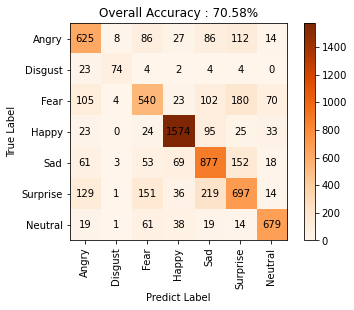

In [29]:
Confusion_Matrix(pt, test_loader)